In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os  
from matplotlib.ticker import PercentFormatter
from scipy.optimize import curve_fit
import itertools

# plot cpu, gpu power pattern for GPGPU apps
def replace_negative_with_average(data, column_name):
    for i in range(1, len(data) - 1):
        if data.at[i, column_name] < 0:
            previous_value = data.at[i - 1, column_name]
            next_value = data.at[i + 1, column_name]
            data.at[i, column_name] = (previous_value + next_value) / 2

def plot_power_CPU_GPU(cpu_filename, gpu_filename, benchmark, x=4,y=3, y_val=450):
    # Load the CSV files into DataFrames
    cpu_data = pd.read_csv(cpu_filename)
    gpu_data = pd.read_csv(gpu_filename)

    # Replace negative values with the average of the previous and next values
    replace_negative_with_average(cpu_data, 'Package Power (W)')
    replace_negative_with_average(gpu_data, 'GPU 0 Power (W)')

    # Plot the data
    plt.figure(figsize=(x, y))
    plt.plot(cpu_data['Time (s)'], cpu_data['Package Power (W)'], label='RAPL Package Power')
    plt.plot(gpu_data['Time (s)'], gpu_data['GPU 0 Power (W)'], label='GPU Power')
    plt.xlabel('Time (s)',fontsize=18)
    plt.ylabel('Power (W)',fontsize=18)
    # plt.title(f'Power Consumption ({benchmark})', pad=40)
    plt.ylim(0, y_val)
    # Position the legend outside the plot
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)
    plt.grid(True, axis="y", alpha=0.5)
    os.makedirs('./fig', exist_ok=True)

    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    
    # Save the figure
    plt.savefig(f'./fig/power_cpu_gpu_{benchmark}.jpg', bbox_inches='tight')
    
    plt.show()

def plot_power_CPU_GPU_DRAM(cpu_filename, gpu_filename, benchmark, x=4,y=3):
    # Load the CSV files into DataFrames
    cpu_data = pd.read_csv(cpu_filename)
    gpu_data = pd.read_csv(gpu_filename)

    # Replace negative values with the average of the previous and next values
    replace_negative_with_average(cpu_data, 'Package Power (W)')
    replace_negative_with_average(gpu_data, 'GPU 0 Power (W)')

    # Plot the data
    plt.figure(figsize=(x, y))
    plt.plot(cpu_data['Time (s)'], cpu_data['Package Power (W)'], label='RAPL Package Power')
    plt.plot(gpu_data['Time (s)'], gpu_data['GPU 0 Power (W)'], label='GPU Power')
    plt.plot(cpu_data['Time (s)'], cpu_data['DRAM Power (W)'], label='DRAM Power')
    plt.xlabel('Time (s)')
    plt.ylabel('Power (W)')
    plt.title(f'Power Consumption ({benchmark})', pad=40)
    # Position the legend outside the plot
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)
    plt.grid(True, axis="y", alpha=0.5)
    
    plt.show()

def plot_power_CPU(cpu_filename, benchmark):
    # Load the CSV file into a DataFrame
    cpu_data = pd.read_csv(cpu_filename)

    # Filter the data to plot every 1 second (assuming data points every 0.1 seconds)
    filtered_cpu_data = cpu_data.iloc[::1]  # Select every 10th row

    # Plot the data
    plt.figure(figsize=(6, 4))
    plt.plot(filtered_cpu_data['Time (s)'], filtered_cpu_data['Package Power (W)'],
             label='RAPL Package Power')
    plt.xlabel('Time (s)')
    plt.ylabel('Power (W)')
    plt.title(f'Power Consumption ({benchmark})', pad=40)
    
    # Position the legend outside the plot
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)
    plt.grid(True, axis="y", alpha=0.5)
    
    # Save the figure in the ./fig directory
    # os.makedirs('./fig', exist_ok=True)
    # plt.savefig(f'./fig/power_cpu_{benchmark}.jpg', bbox_inches='tight')
    
    # Display the plot
    plt.show()




# plot the power capping results for GPGPU apps
def plot_power_cap(file_cpu_cap, file_gpu_cap, benchmark,altis):
    def calculate_modified_average(runtimes):
        """Calculate the average runtime after dropping the min and max values."""
        if len(runtimes) > 2:
            return (sum(runtimes) - min(runtimes) - max(runtimes)) / (len(runtimes) - 2)
        return sum(runtimes) / len(runtimes)  # Return average if we can't drop values

    def preprocess_dataframe(file_path):
        """Read and preprocess the data from a CSV file."""
        df = pd.read_csv(file_path)
        # Group by 'CPU Cap (W)' and 'GPU Cap (W)' and aggregate 'Runtime (s)'
        agg_df = df.groupby(['CPU Cap (W)', 'GPU Cap (W)'])['Runtime (s)'].apply(list).reset_index()
        agg_df['Runtime (s)'] = agg_df['Runtime (s)'].apply(calculate_modified_average)
        return agg_df
    
    # Set up subplot environment
    fig, axs = plt.subplots(1, 2, figsize=(20, 6))

    # Process and plot CPU cap data
    df_cpu = preprocess_dataframe(file_cpu_cap)
    # Find base runtime for max CPU Cap
    base_runtime_cpu = df_cpu[df_cpu['CPU Cap (W)'] == df_cpu['CPU Cap (W)'].max()]['Runtime (s)'].iloc[0]
    df_cpu['Performance (%)'] = (base_runtime_cpu / df_cpu['Runtime (s)']) * 100

    # max cpu power cap is 125 for ALTIS, so 250-125 = 125 which is the "decrease start point"
    if altis:
        cap = 125
    else:
        cap = 0
        
    df_cpu['CPU Cap Decrease (W)'] = df_cpu['CPU Cap (W)'].max() + cap - df_cpu['CPU Cap (W)']  # Adjusted for ALTIS benchmark
    axs[0].plot(df_cpu['CPU Cap Decrease (W)'], df_cpu['Performance (%)'], 'o--', linewidth=5, markersize=10)
    axs[0].set_title(f'{benchmark}: fixed max GPU cap', fontsize=20)
    axs[0].set_xlabel('CPU Cap Decrease (W)', fontsize=20)
    axs[0].set_ylabel('Application Performance (%)', fontsize=20)

    # Process and plot GPU cap data
    df_gpu = preprocess_dataframe(file_gpu_cap)
    # Find base runtime for max GPU Cap
    base_runtime_gpu = df_gpu[df_gpu['GPU Cap (W)'] == df_gpu['GPU Cap (W)'].max()]['Runtime (s)'].iloc[0]
    df_gpu['Performance (%)'] = (base_runtime_gpu / df_gpu['Runtime (s)']) * 100
    df_gpu['GPU Cap Decrease (W)'] = df_gpu['GPU Cap (W)'].max() - df_gpu['GPU Cap (W)']
    axs[1].plot(df_gpu['GPU Cap Decrease (W)'], df_gpu['Performance (%)'], 'D--', color='r', linewidth=5, markersize=10)
    axs[1].set_title(f'{benchmark}: fixed max CPU cap', fontsize=20)
    axs[1].set_xlabel('GPU Cap Decrease (W)', fontsize=20)
    axs[1].set_ylabel('Application Performance (%)', fontsize=20)

    for ax in axs:
        ax.tick_params(axis='x', labelsize=20)
        ax.tick_params(axis='y', labelsize=20)
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()






def plot_power_cap_all(file_cpu_cap, file_gpu_cap, benchmarks, altis, filename):
    
    def preprocess_dataframe(df):
        # Group by 'CPU Cap (W)' and 'GPU Cap (W)' and calculate the average runtime 
        def custom_agg(x):
            if len(x) > 2:
                return (np.sum(x) - np.min(x) - np.max(x)) / (len(x) - 2)
            else:
                return np.mean(x)  # Use average if not enough values to drop min and max
        
        processed_df = df.groupby(['CPU Cap (W)', 'GPU Cap (W)'])['Runtime (s)'].agg(custom_agg).reset_index()
        return processed_df

    # Set up the figure for subplots with shared y-axis
    fig, axs = plt.subplots(1, 2, figsize=(24, 8), sharey=True)
    
    markers = ['D', '+', 'x', 'o', 's', '*', '^']
    colors = ['r', 'g', 'b', 'purple', 'cyan', 'orange', 'pink']
    
    # Process and plot data for each benchmark
    for cpu_file, gpu_file, benchmark, marker, color in zip(file_cpu_cap, file_gpu_cap, benchmarks, markers, colors):
        # CPU cap data
        df_cpu = pd.read_csv(cpu_file)
        df_cpu = preprocess_dataframe(df_cpu)
        df_cpu = df_cpu.sort_values(by='CPU Cap (W)', ascending=False)  # Sort descending
        base_runtime_cpu = df_cpu.iloc[0]['Runtime (s)']  # Max CPU cap runtime
        df_cpu['Performance (%)'] = 100 * base_runtime_cpu / df_cpu['Runtime (s)']

        # Plot CPU power vs. performance
        axs[0].plot(df_cpu['CPU Cap (W)'], df_cpu['Performance (%)'], marker=marker, 
                    linestyle='-', color=color, linewidth=2, markersize=8, label=f"{benchmark}")
        axs[0].set_xlabel('CPU Power (W)', fontsize=25)

        # GPU cap data
        df_gpu = pd.read_csv(gpu_file)
        df_gpu = preprocess_dataframe(df_gpu)
        df_gpu = df_gpu.sort_values(by='GPU Cap (W)', ascending=False)  # Sort descending
        base_runtime_gpu = df_gpu.iloc[0]['Runtime (s)']  # Max GPU cap runtime
        df_gpu['Performance (%)'] = 100 * base_runtime_gpu / df_gpu['Runtime (s)']

        # Plot GPU power vs. performance
        axs[1].plot(df_gpu['GPU Cap (W)'], df_gpu['Performance (%)'], marker=marker, 
                    linestyle='-', color=color, linewidth=2, markersize=8, label=f"{benchmark}")
        axs[1].set_xlabel('GPU Power (W)', fontsize=25)

    # Set common y-axis label
    fig.text(0.04, 0.5, 'Application Performance (%)', va='center', rotation='vertical', fontsize=25)
    
    # Set titles and adjust layout
    axs[0].set_title('CPU Power vs. Performance', fontsize=25)
    axs[1].set_title('GPU Power vs. Performance', fontsize=25)
    
    for ax in axs:
        ax.tick_params(axis='both', which='major', labelsize=20)
        ax.legend(fontsize=20)
        ax.grid(True)

    # Adjust layout for better spacing
    plt.tight_layout(rect=[0.05, 0, 1, 1])
    os.makedirs('./fig', exist_ok=True)
    
    # Save the figure
    plt.savefig(f'./fig/{filename}.jpg', bbox_inches='tight')
    plt.show()




### CPU-only benchamrk
# Function to perform polynomial fitting ensuring the curve passes through (max_x, 1)
def fit_data_polynomial(x_data, y_data, degree, max_x):
    coefficients = np.polyfit(x_data, y_data, degree)
    polynomial = np.poly1d(coefficients)
    
    # Compute the original y_fit values
    y_fit = polynomial(x_data)
    
    # Adjust y_fit to make the rightmost point equal to 1
    shift = 1 - polynomial(max_x)
    y_fit += shift
    
    return y_fit

# Process the data and perform polynomial fitting
def process_file_cpu_only(file_path, degree=3):
    df = pd.read_csv(file_path)
    
    # Filter out rows with non-positive CPU_E
    df_filtered = df[(df['CPU_E (J)'] > 0) & (df['CPU Cap (W)'] > 70)]
    
    # Group by CPU Cap and calculate the mean values
    group_cpu = df_filtered.groupby('CPU Cap (W)', as_index=False).agg({
        'Runtime (s)': 'mean',
        'CPU_E (J)': 'mean'
    }).sort_values('CPU Cap (W)', ascending=False)
    
    # Calculate EDP and normalize it against the baseline
    group_cpu['EDP'] = group_cpu['Runtime (s)'] * group_cpu['CPU_E (J)']
    baseline = group_cpu.iloc[0]
    baseline_runtime = baseline['Runtime (s)']
    baseline_energy = baseline['CPU_E (J)']
    baseline_edp = baseline['EDP']
    
    
    group_cpu['Normalized Speedup'] = baseline_runtime / group_cpu['Runtime (s)']
    group_cpu['Normalized Energy'] = group_cpu['CPU_E (J)'] / baseline_energy
    group_cpu['Normalized EDP'] = group_cpu['EDP'] / baseline_edp

    



    max_cpu_cap = group_cpu['CPU Cap (W)'].max()
    
    # Polynomial degree can be adjusted for fitting
    polynomial_degree = degree
    group_cpu['Fitted Speedup'] = fit_data_polynomial(group_cpu['CPU Cap (W)'], group_cpu['Normalized Speedup'], polynomial_degree, max_cpu_cap)
    group_cpu['Fitted Energy'] = fit_data_polynomial(group_cpu['CPU Cap (W)'], group_cpu['Normalized Energy'], polynomial_degree, max_cpu_cap)
    group_cpu['Fitted EDP'] = fit_data_polynomial(group_cpu['CPU Cap (W)'], group_cpu['Normalized EDP'], polynomial_degree, max_cpu_cap)
    
    return group_cpu

# Plot the performance, energy, and EDP with fitted data
def plot_performance_energy_all_cpu_only(file_paths, apps):
    fig, axs = plt.subplots(1, 3, figsize=(21, 7))
    markers = ['o', 's', 'D', '^', 'x', '+', '*', '<', '>', 'o', 's', 'D', '^', 'x', '+']
  
    for file_path, label, marker in zip(file_paths, apps, markers):
        degree = 5
        if label == "XSBench_omp":
            degree = 5
        processed_data = process_file_cpu_only(file_path,degree)
        
        #axs[0].plot(processed_data['CPU Cap (W)'], processed_data['Normalized Speedup'], marker=marker, linestyle='-', label=label)
        axs[0].plot(processed_data['CPU Cap (W)'], processed_data['Fitted Speedup'], marker=marker, linestyle='-', label=label)

        # axs[1].plot(processed_data['CPU Cap (W)'], processed_data['Normalized Energy'], marker=marker, linestyle='-', label=label)
        axs[1].plot(processed_data['CPU Cap (W)'], processed_data['Fitted Energy'], marker=marker, linestyle='-', label=label)
        
        # axs[2].plot(processed_data['CPU Cap (W)'], processed_data['Normalized EDP'], marker=marker, linestyle='-', label=label)
        axs[2].plot(processed_data['CPU Cap (W)'], processed_data['Fitted EDP'], marker=marker, linestyle='-', label=label)
       
       
    for ax in axs:
        ax.set_xlabel('CPU Power Cap (W)', fontsize=15)
        ax.set_ylabel('Metric Value', fontsize=15)
        ax.tick_params(axis='x', labelsize=15)
        ax.tick_params(axis='y', labelsize=15)
        ax.legend()
        ax.grid(True)

    axs[0].set_ylabel('Normalized Speedup', fontsize=15)
    axs[1].set_ylabel('Normalized Energy Consumption', fontsize=15)
    axs[2].set_ylabel('Normalized EDP', fontsize=15)
    axs[0].set_title('Speedup vs CPU Power Cap')
    axs[1].set_title('Energy vs CPU Power Cap')
    axs[2].set_title('EDP vs CPU Power Cap')

    plt.tight_layout()
    plt.show()

# Altis

## Dual Cap

### Generate Performance CSV

In [6]:
import os
import pandas as pd

base_dir = "./altis_power_cap_res/2_dual_cap"

# List of benchmark applications
benchmarks = ['gemm', 'gups', 'cfd', 'maxflops', 'pathfinder', 'bfs', 'particlefilter_float',
              'cfd_double', 'kmeans', 'lavamd', 'fdtd2d', 'pathfinder', 'nw',
              'particlefilter_naive', 'raytracing', 'srad', 'sort', 'where']

# Iterate over each benchmark application folder
for app in benchmarks:
    app_dir = os.path.join(base_dir, app)
    if not os.path.isdir(app_dir):
        continue  # Skip if not a directory

    performance_data = []

    # Process each file in the application folder
    for filename in os.listdir(app_dir):
        if filename.endswith("_cpu_metrics.csv"):
            # Extract CPU and GPU power cap from filename
            parts = filename.split("_")
            cpu_power_cap, gpu_power_cap = parts[0], parts[1]

            # Read the IPS and Memory Throughput file
            cpu_metrics_file = os.path.join(app_dir, filename)
            df_cpu_metrics = pd.read_csv(cpu_metrics_file)
            avg_ips = df_cpu_metrics["IPS"].mean()
            avg_mem_throughput = df_cpu_metrics["Memory Throughput (MB/s)"].mean()

            # Read the GPU metrics file
            gpu_metrics_filename = f"{cpu_power_cap}_{gpu_power_cap}_gpu_metrics.csv"
            gpu_metrics_file = os.path.join(app_dir, gpu_metrics_filename)
            if os.path.exists(gpu_metrics_file):
                df_gpu_metrics = pd.read_csv(gpu_metrics_file)
                avg_sm_clock = df_gpu_metrics["SM Clock (MHz)"].mean()
                avg_dram_active = df_gpu_metrics["DRAM Active"].mean()
                avg_fp_active = df_gpu_metrics["FP16 Active"].mean() + \
                               df_gpu_metrics["FP32 Active"].mean() + \
                               df_gpu_metrics["FP64 Active"].mean()
            else:
                avg_sm_clock = avg_dram_active = avg_fp_active = None

            # Read the CPU power file to get runtime (performance)
            cpu_power_filename = f"{cpu_power_cap}_{gpu_power_cap}_cpu_power.csv"
            cpu_power_file = os.path.join(app_dir, cpu_power_filename)
            if os.path.exists(cpu_power_file):
                df_cpu_power = pd.read_csv(cpu_power_file)
                runtime = df_cpu_power["Time (s)"].iloc[-1]  # Get last value of the Time column
            else:
                runtime = None

            # Store results
            performance_data.append({
                "CPU Power Cap": int(cpu_power_cap),
                "GPU Power Cap": int(gpu_power_cap),
                "IPS": avg_ips,
                "Memory Throughput": avg_mem_throughput,
                "SM Clock": avg_sm_clock,
                "DRAM Active": avg_dram_active,
                "FP Active": avg_fp_active,
                "Performance": runtime
            })

    # Save to CSV
    if performance_data:
        df_output = pd.DataFrame(performance_data)

        # Normalize IPS, Memory Throughput, and Performance
        df_output["IPS"] = df_output["IPS"] / df_output["IPS"].max()
        df_output["Memory Throughput"] = df_output["Memory Throughput"] / df_output["Memory Throughput"].max()
        df_output["Performance"] = df_output["Performance"].min() / df_output["Performance"]

        # Normalize GPU-related metrics with a safeguard against zero max values
        for col in ["SM Clock", "DRAM Active", "FP Active"]:
            max_value = df_output[col].max()
            if max_value == 0 or pd.isna(max_value):
                df_output[col] = 0  # Set all values to 0 if max is 0
            else:
                df_output[col] = df_output[col] / max_value

        # Replace NaN values with 0
        df_output = df_output.fillna(0)

        # Sort values
        df_output = df_output.sort_values(by=["CPU Power Cap", "GPU Power Cap"], ascending=[True, True])

        # Save output
        output_file = os.path.join(base_dir, f"{app}_performance.csv")
        df_output.to_csv(output_file, index=False)



### Performance vs Power Cap

/tmp/ipykernel_1864311/1175263053.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab20", len(benchmarks)).colors  # Generate distinct colors


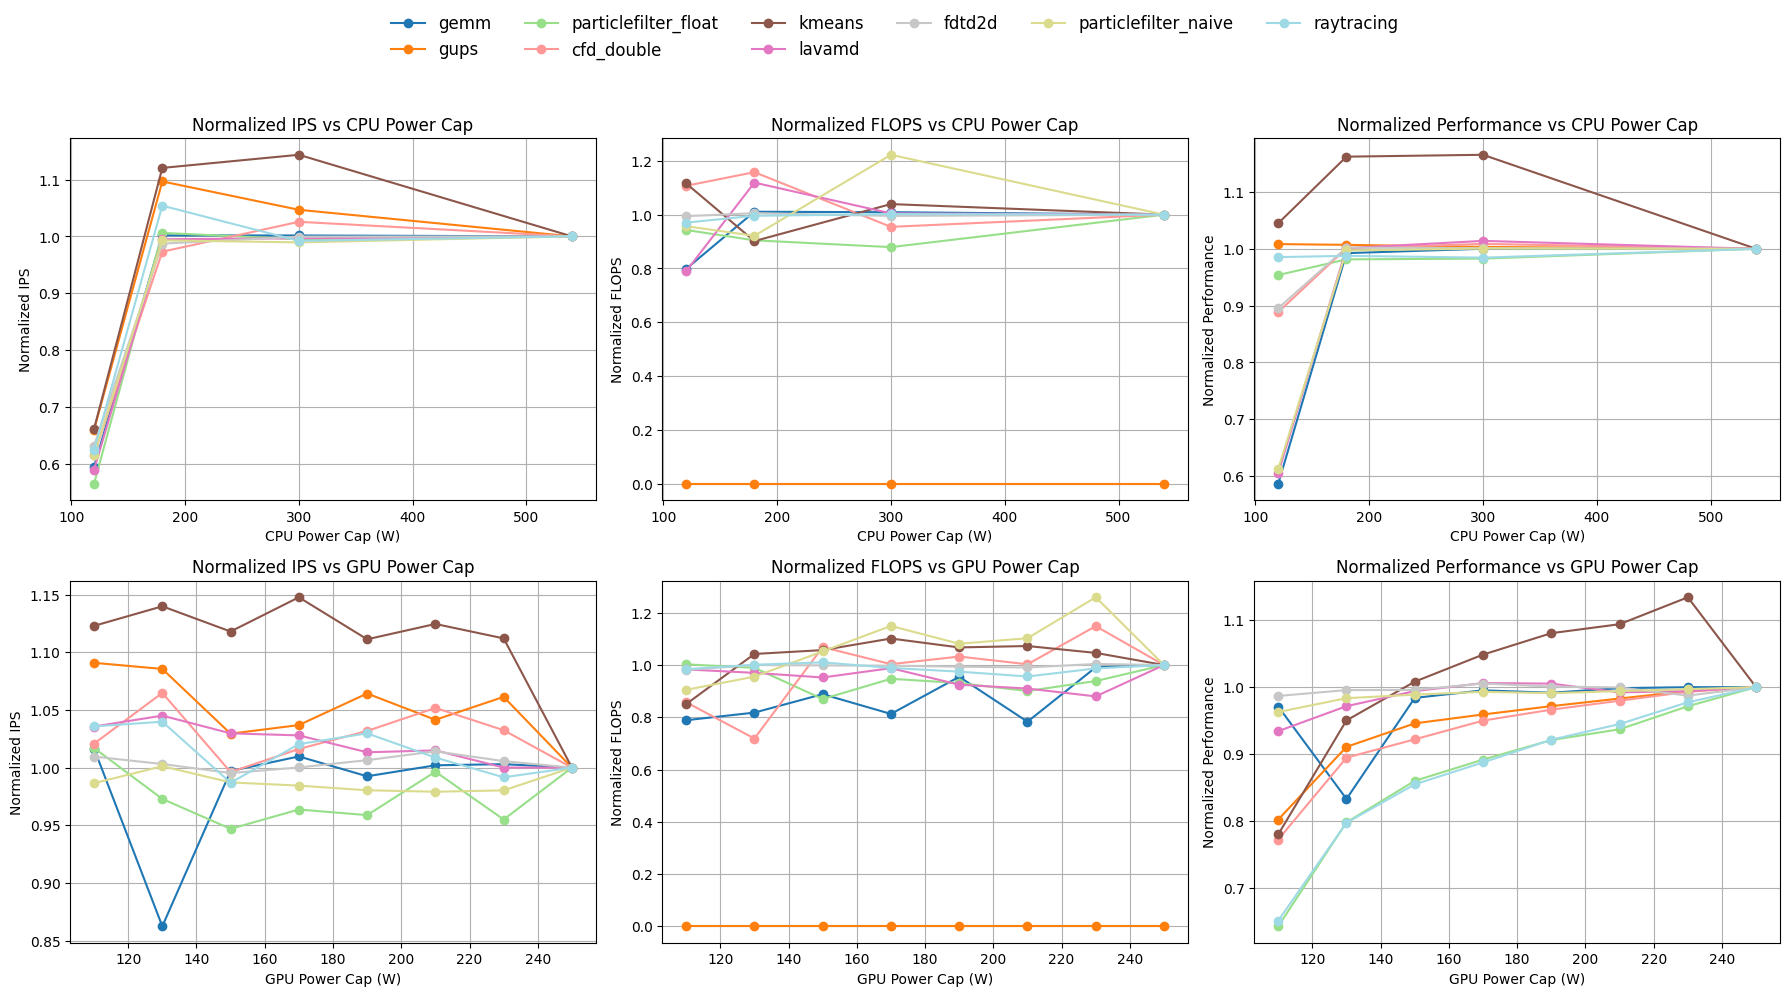

In [6]:
def plot_normalized_performance(filenames, benchmarks):
    cpu_power_limits = [200, 190, 180, 170, 160, 150, 140, 130, 120]
    gpu_power_limits = [250, 240, 230, 220, 210, 200, 190, 180, 170, 160, 150]

    cpu_ips_data = {app: [] for app in benchmarks}
    cpu_flops_data = {app: [] for app in benchmarks}
    cpu_runtime_data = {app: [] for app in benchmarks}

    gpu_ips_data = {app: [] for app in benchmarks}
    gpu_flops_data = {app: [] for app in benchmarks}
    gpu_runtime_data = {app: [] for app in benchmarks}

    colors = plt.cm.get_cmap("tab20", len(benchmarks)).colors  # Generate distinct colors
    color_cycle = itertools.cycle(colors)
    app_colors = {app: next(color_cycle) for app in benchmarks}

    for file, app in zip(filenames, benchmarks):
        df = pd.read_csv(file)

        # Extract baseline values for normalization (220_250)
        baseline = df[(df["CPU Power Cap"] == 540) & (df["GPU Power Cap"] == 250)]
        if baseline.empty:
            continue
        base_ips = baseline["IPS"].values[0]
        base_flops = baseline["FLOPS"].values[0]
        base_runtime = baseline["Performance"].values[0]

        if base_flops == 0 or np.isnan(base_flops):
            base_flops = 1  # Avoid division errors
        if base_runtime == 0 or np.isnan(base_runtime):
            base_runtime = 1  # Avoid division errors

        for cpu_power in cpu_power_limits:
            subset = df[(df["CPU Power Cap"] == cpu_power) & (df["GPU Power Cap"] == 250)]
            if not subset.empty:
                norm_ips = subset["IPS"].values[0] / base_ips if base_ips else np.nan
                norm_flops = subset["FLOPS"].values[0] / base_flops if base_flops else np.nan
                norm_runtime = subset["Performance"].values[0] / base_runtime if base_runtime else np.nan
                cpu_ips_data[app].append((cpu_power, norm_ips))
                cpu_flops_data[app].append((cpu_power, norm_flops))
                cpu_runtime_data[app].append((cpu_power, norm_runtime))

        for gpu_power in gpu_power_limits:
            subset = df[(df["CPU Power Cap"] == 540) & (df["GPU Power Cap"] == gpu_power)]
            if not subset.empty:
                norm_ips = subset["IPS"].values[0] / base_ips if base_ips else np.nan
                norm_flops = subset["FLOPS"].values[0] / base_flops if base_flops else np.nan
                norm_runtime = subset["Performance"].values[0] / base_runtime if base_runtime else np.nan
                gpu_ips_data[app].append((gpu_power, norm_ips))
                gpu_flops_data[app].append((gpu_power, norm_flops))
                gpu_runtime_data[app].append((gpu_power, norm_runtime))

    fig, axs = plt.subplots(2, 3, figsize=(18, 10))  # 2 rows, 3 columns
    
    # Plot CPU IPS
    for app, data in cpu_ips_data.items():
        df_cpu = pd.DataFrame(data, columns=["CPU Power Cap", "Normalized IPS"])
        if not df_cpu.empty:
            axs[0, 0].plot(df_cpu["CPU Power Cap"], df_cpu["Normalized IPS"], label=f"{app}", marker="o", color=app_colors[app])
    axs[0, 0].set_xlabel("CPU Power Cap (W)")
    axs[0, 0].set_ylabel("Normalized IPS")
    axs[0, 0].set_title("Normalized IPS vs CPU Power Cap")
    axs[0, 0].grid()

    # Plot CPU FLOPS
    for app, data in cpu_flops_data.items():
        df_cpu = pd.DataFrame(data, columns=["CPU Power Cap", "Normalized FLOPS"])
        if not df_cpu.empty:
            axs[0, 1].plot(df_cpu["CPU Power Cap"], df_cpu["Normalized FLOPS"], label=f"{app}", marker="o", color=app_colors[app])
    axs[0, 1].set_xlabel("CPU Power Cap (W)")
    axs[0, 1].set_ylabel("Normalized FLOPS")
    axs[0, 1].set_title("Normalized FLOPS vs CPU Power Cap")
    axs[0, 1].grid()

    # Plot CPU Runtime
    for app, data in cpu_runtime_data.items():
        df_cpu = pd.DataFrame(data, columns=["CPU Power Cap", "Normalized Performance"])
        if not df_cpu.empty:
            axs[0, 2].plot(df_cpu["CPU Power Cap"], df_cpu["Normalized Performance"], label=f"{app}", marker="o", color=app_colors[app])
    axs[0, 2].set_xlabel("CPU Power Cap (W)")
    axs[0, 2].set_ylabel("Normalized Performance")
    axs[0, 2].set_title("Normalized Performance vs CPU Power Cap")
    axs[0, 2].grid()

    # Plot GPU IPS
    for app, data in gpu_ips_data.items():
        df_gpu = pd.DataFrame(data, columns=["GPU Power Cap", "Normalized IPS"])
        if not df_gpu.empty:
            axs[1, 0].plot(df_gpu["GPU Power Cap"], df_gpu["Normalized IPS"], label=f"{app}", marker="o", color=app_colors[app])
    axs[1, 0].set_xlabel("GPU Power Cap (W)")
    axs[1, 0].set_ylabel("Normalized IPS")
    axs[1, 0].set_title("Normalized IPS vs GPU Power Cap")
    axs[1, 0].grid()

    # Plot GPU FLOPS
    for app, data in gpu_flops_data.items():
        df_gpu = pd.DataFrame(data, columns=["GPU Power Cap", "Normalized FLOPS"])
        if not df_gpu.empty:
            axs[1, 1].plot(df_gpu["GPU Power Cap"], df_gpu["Normalized FLOPS"], label=f"{app}", marker="o", color=app_colors[app])
    axs[1, 1].set_xlabel("GPU Power Cap (W)")
    axs[1, 1].set_ylabel("Normalized FLOPS")
    axs[1, 1].set_title("Normalized FLOPS vs GPU Power Cap")
    axs[1, 1].grid()

    # Plot GPU Runtime
    for app, data in gpu_runtime_data.items():
        df_gpu = pd.DataFrame(data, columns=["GPU Power Cap", "Normalized Performance"])
        if not df_gpu.empty:
            axs[1, 2].plot(df_gpu["GPU Power Cap"], df_gpu["Normalized Performance"], label=f"{app}", marker="o", color=app_colors[app])
    axs[1, 2].set_xlabel("GPU Power Cap (W)")
    axs[1, 2].set_ylabel("Normalized Performance")
    axs[1, 2].set_title("Normalized Performance vs GPU Power Cap")
    axs[1, 2].grid()

    # Add legend
    handles, labels = axs[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=6, fontsize=12, frameon=False)

    plt.tight_layout(rect=[0, 0, 1, 0.9])
    plt.show()


# Define file paths
data_cap_dir = "./altis_power_cap_res/dual_cap/"
benchmarks = ['gemm', 'gups', 'particlefilter_float',
               'cfd_double', 'kmeans', 'lavamd', 'fdtd2d',
               'particlefilter_naive', 'raytracing']




filenames = [data_cap_dir + f"{benchmark}_performance.csv" for benchmark in benchmarks]

# Run the function
plot_normalized_performance(filenames, benchmarks)

## CPU Cap

In [12]:
## including mem throughput
import os
import pandas as pd

base_dir = "./altis_power_cap_res/cpu_cap"

# List of benchmark applications
benchmarks = ['gemm', 'gups', 'cfd','maxflops','pathfinder','bfs','particlefilter_float',
              'cfd_double', 'kmeans', 'lavamd', 'fdtd2d', 'pathfinder', 'nw',
              'particlefilter_naive', 'raytracing', 'srad','sort','where']

# Iterate over each benchmark application folder
for app in benchmarks:
    app_dir = os.path.join(base_dir, app)
    if not os.path.isdir(app_dir):
        continue  # Skip if not a directory

    performance_data = []

    # Process each file in the application folder
    for filename in os.listdir(app_dir):
        if filename.endswith("_ips.csv"):
            # Extract CPU and GPU power cap from filename
            parts = filename.split("_")
            cpu_power_cap, gpu_power_cap = parts[0], parts[1]

            # Read the IPS file
            ips_file = os.path.join(app_dir, filename)
            df_ips = pd.read_csv(ips_file)
            avg_ips = df_ips["IPS"].mean()

            # Read the corresponding Memory Throughput file
            mem_filename = f"{cpu_power_cap}_{gpu_power_cap}_mem.csv"
            mem_file = os.path.join(app_dir, mem_filename)
            if os.path.exists(mem_file):
                df_mem = pd.read_csv(mem_file)
                avg_mem_throughput = df_mem["Memory Throughput (MB/s)"].mean()
            else:
                avg_mem_throughput = None

            # Read the GPU power file to get runtime
            gpu_power_filename = f"{cpu_power_cap}_{gpu_power_cap}_cpu_power.csv"
            gpu_power_file = os.path.join(app_dir, gpu_power_filename)
            if os.path.exists(gpu_power_file):
                df_gpu_power = pd.read_csv(gpu_power_file)
                runtime = df_gpu_power["Time (s)"].iloc[-1]  # Get last value of the Time column
            else:
                runtime = None

            # Store results
            performance_data.append({
                "CPU Power Cap": int(cpu_power_cap),
                "GPU Power Cap": int(gpu_power_cap),
                "IPS": avg_ips,
                "Memory Throughput": avg_mem_throughput,
                "Performance": runtime
            })

    # Save to CSV
    if performance_data:
        df_output = pd.DataFrame(performance_data)

        # Normalize IPS, Memory Throughput, and Runtime
        df_output["IPS"] = df_output["IPS"] / df_output["IPS"].max()
        df_output["Memory Throughput"] = df_output["Memory Throughput"] / df_output["Memory Throughput"].max()
        df_output["Performance"] = df_output["Performance"].min() / df_output["Performance"]

        # Replace NaN values with 0
        df_output = df_output.fillna(0)

        df_output = df_output.sort_values(by=["CPU Power Cap", "GPU Power Cap"], ascending=[True, True])
        output_file = os.path.join(base_dir, f"{app}_performance.csv")
        df_output.to_csv(output_file, index=False)

/tmp/ipykernel_1974470/2503381007.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab20", len(benchmarks)).colors  # Generate distinct colors


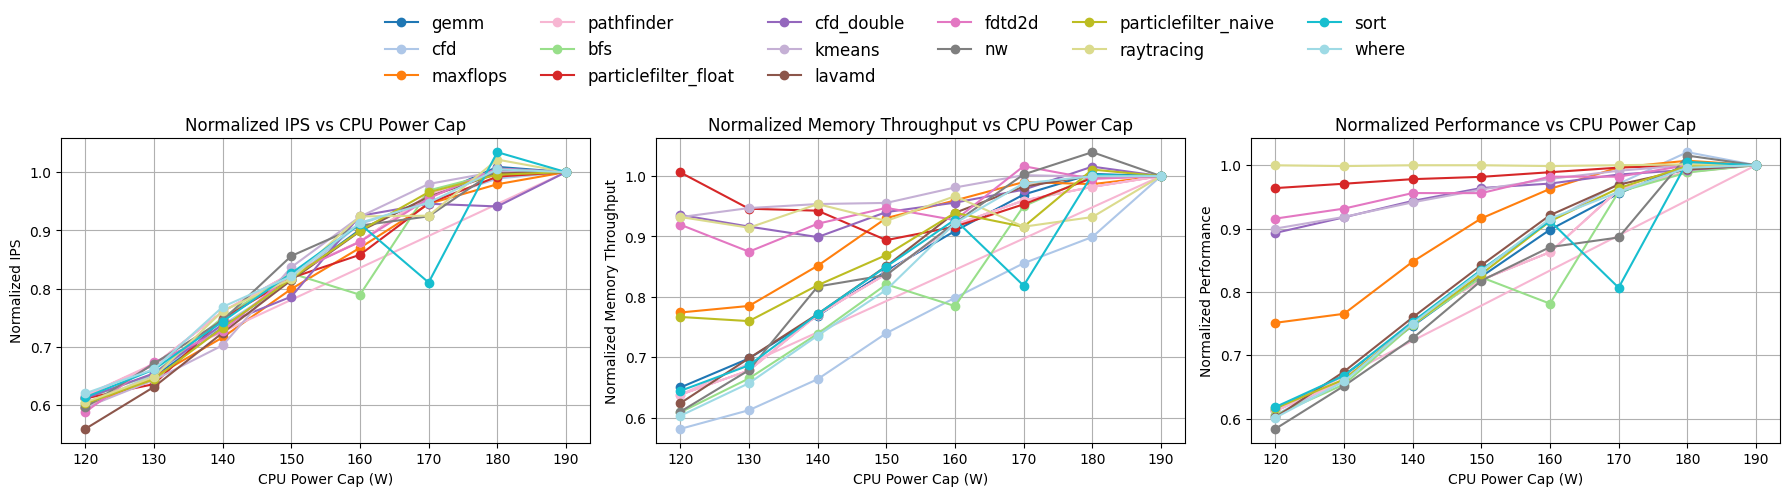

In [27]:
base_dir = "./altis_power_cap_res/cpu_cap/"

# List of benchmark applications

# Function to plot normalized performance
def plot_normalized_performance(filenames, benchmarks):
    cpu_power_limits = [190, 180, 170,160,150, 140,130, 120]
    
    cpu_ips_data = {app: [] for app in benchmarks}
    cpu_mem_data = {app: [] for app in benchmarks}
    cpu_runtime_data = {app: [] for app in benchmarks}

    colors = plt.cm.get_cmap("tab20", len(benchmarks)).colors  # Generate distinct colors
    color_cycle = itertools.cycle(colors)
    app_colors = {app: next(color_cycle) for app in benchmarks}

    for file, app in zip(filenames, benchmarks):
        df = pd.read_csv(file)

        # Extract baseline values for normalization (CPU 540W, GPU 250W)
        baseline = df[(df["CPU Power Cap"] == 190) & (df["GPU Power Cap"] == 250)]
        if baseline.empty:
            continue
        base_ips = baseline["IPS"].values[0]
        base_mem = baseline["Memory Throughput"].values[0]
        base_runtime = baseline["Performance"].values[0]

        for cpu_power in cpu_power_limits:
            subset = df[(df["CPU Power Cap"] == cpu_power) & (df["GPU Power Cap"] == 250)]
            if not subset.empty:
                norm_ips = subset["IPS"].values[0] / base_ips if base_ips else np.nan
                norm_mem = subset["Memory Throughput"].values[0] / base_mem if base_mem else np.nan
                norm_runtime = subset["Performance"].values[0] / base_runtime if base_runtime else np.nan
                cpu_ips_data[app].append((cpu_power, norm_ips))
                cpu_mem_data[app].append((cpu_power, norm_mem))
                cpu_runtime_data[app].append((cpu_power, norm_runtime))

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns
    
    # Plot CPU IPS
    for app, data in cpu_ips_data.items():
        df_cpu = pd.DataFrame(data, columns=["CPU Power Cap", "Normalized IPS"])
        if not df_cpu.empty:
            axs[0].plot(df_cpu["CPU Power Cap"], df_cpu["Normalized IPS"], label=f"{app}", marker="o", color=app_colors[app])
    axs[0].set_xlabel("CPU Power Cap (W)")
    axs[0].set_ylabel("Normalized IPS")
    axs[0].set_title("Normalized IPS vs CPU Power Cap")
    axs[0].grid()

    # Plot CPU Memory Throughput
    for app, data in cpu_mem_data.items():
        df_cpu = pd.DataFrame(data, columns=["CPU Power Cap", "Normalized Memory Throughput"])
        if not df_cpu.empty:
            axs[1].plot(df_cpu["CPU Power Cap"], df_cpu["Normalized Memory Throughput"], label=f"{app}", marker="o", color=app_colors[app])
    axs[1].set_xlabel("CPU Power Cap (W)")
    axs[1].set_ylabel("Normalized Memory Throughput")
    axs[1].set_title("Normalized Memory Throughput vs CPU Power Cap")
    axs[1].grid()

    # Plot CPU Performance
    for app, data in cpu_runtime_data.items():
        df_cpu = pd.DataFrame(data, columns=["CPU Power Cap", "Normalized Performance"])
        if not df_cpu.empty:
            axs[2].plot(df_cpu["CPU Power Cap"], df_cpu["Normalized Performance"], label=f"{app}", marker="o", color=app_colors[app])
    axs[2].set_xlabel("CPU Power Cap (W)")
    axs[2].set_ylabel("Normalized Performance")
    axs[2].set_title("Normalized Performance vs CPU Power Cap")
    axs[2].grid()
    
    # Add legend
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=6, fontsize=12, frameon=False)
    
    plt.tight_layout(rect=[0, 0, 1, 0.8])
    plt.show()


benchmarks = ['gemm', 'gups', 'cfd','maxflops','pathfinder','bfs','particlefilter_float',
              'cfd_double', 'kmeans', 'lavamd', 'fdtd2d', 'pathfinder', 'nw',
              'particlefilter_naive', 'raytracing','sort','where','srad']

# benchmarks = ['gemm', 'cfd','maxflops','pathfinder','bfs','particlefilter_float',
#               'cfd_double', 'kmeans', 'lavamd', 'fdtd2d', 'pathfinder', 'nw',
#               'particlefilter_naive', 'raytracing','sort','where']

# benchmarks = ['nw']

filenames = [base_dir + f"{benchmark}_performance.csv" for benchmark in benchmarks]

# Run the function
plot_normalized_performance(filenames, benchmarks)


## observations & insights:


1. power capping with RAPL first limit the core frequency to reduce power consumption, while keep uncore frequency unchanged. (UPS paper also mentioned this)
2. CPU core-instenive apps are affected significantly by CPU power capping via RAPL, while cpu uncore-intensive apps are not affected too much by CPU power capping via RAPL.
3. These observations suggested that when do power capping for GPU-enabled applications (since we only do the experiment for these apps), we should indentify whether it is core-intensive or uncore-intensive, then determine which component and how much power should be capped. 

## GPU Cap

In [2]:
base_dir = "./altis_power_cap_res/gpu_cap"
benchmarks = ['gemm', 'gups', 'cfd','maxflops','pathfinder','bfs','particlefilter_float',
              'cfd_double', 'kmeans', 'lavamd', 'fdtd2d', 'pathfinder', 'nw',
              'particlefilter_naive', 'raytracing', 'srad','sort','where']


# Iterate over each benchmark application folder to collect and store data
for app in benchmarks:
    app_dir = os.path.join(base_dir, app)
    if not os.path.isdir(app_dir):
        continue  # Skip if not a directory

    performance_data = []

    # Process each file in the application folder
    for filename in os.listdir(app_dir):
        if filename.endswith("_ips.csv"):
            # Extract CPU and GPU power cap from filename
            parts = filename.split("_")
            cpu_power_cap, gpu_power_cap = parts[0], parts[1]

            # Read the IPS file
            ips_file = os.path.join(app_dir, filename)
            df_ips = pd.read_csv(ips_file)
            avg_ips = df_ips["IPS"].mean()

            # Read the Memory Throughput file
            mem_filename = f"{cpu_power_cap}_{gpu_power_cap}_mem.csv"
            mem_file = os.path.join(app_dir, mem_filename)
            if os.path.exists(mem_file):
                df_mem = pd.read_csv(mem_file)
                avg_mem_throughput = df_mem["Memory Throughput (MB/s)"].mean()
            else:
                avg_mem_throughput = None

            # Read the GPU metrics file to get average SM Clock
            gpu_metrics_filename = f"{cpu_power_cap}_{gpu_power_cap}_gpu_metrics.csv"
            gpu_metrics_file = os.path.join(app_dir, gpu_metrics_filename)
            if os.path.exists(gpu_metrics_file):
                df_gpu_metrics = pd.read_csv(gpu_metrics_file)
                avg_sm_clock = df_gpu_metrics["SM Clock (MHz)"].mean()
            else:
                avg_sm_clock = None

            # Read the GPU power file to get runtime
            gpu_power_filename = f"{cpu_power_cap}_{gpu_power_cap}_cpu_power.csv"
            gpu_power_file = os.path.join(app_dir, gpu_power_filename)
            if os.path.exists(gpu_power_file):
                df_gpu_power = pd.read_csv(gpu_power_file)
                runtime = df_gpu_power["Time (s)"].iloc[-1]  # Get last value of the Time column
            else:
                runtime = None

            # Store results
            performance_data.append({
                "CPU Power Cap": int(cpu_power_cap),
                "GPU Power Cap": int(gpu_power_cap),
                "IPS": avg_ips,
                "Memory Throughput": avg_mem_throughput,
                "Performance": runtime,
                "SM Clock": avg_sm_clock
            })

    # Save to CSV
    if performance_data:
        df_output = pd.DataFrame(performance_data)

        # Normalize IPS, Memory Throughput, Runtime, and SM Clock
        df_output["IPS"] = df_output["IPS"] / df_output["IPS"].max()
        df_output["Memory Throughput"] = df_output["Memory Throughput"] / df_output["Memory Throughput"].max()
        df_output["Performance"] = df_output["Performance"].min() / df_output["Performance"]
        df_output["SM Clock"] = df_output["SM Clock"] / df_output["SM Clock"].max()

        # Replace NaN values with 0
        df_output = df_output.fillna(0)

        df_output = df_output.sort_values(by=["CPU Power Cap", "GPU Power Cap"], ascending=[True, True])
        output_file = os.path.join(base_dir, f"{app}_performance.csv")
        df_output.to_csv(output_file, index=False)

/tmp/ipykernel_269124/3365771450.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab20", len(benchmarks)).colors  # Generate distinct colors


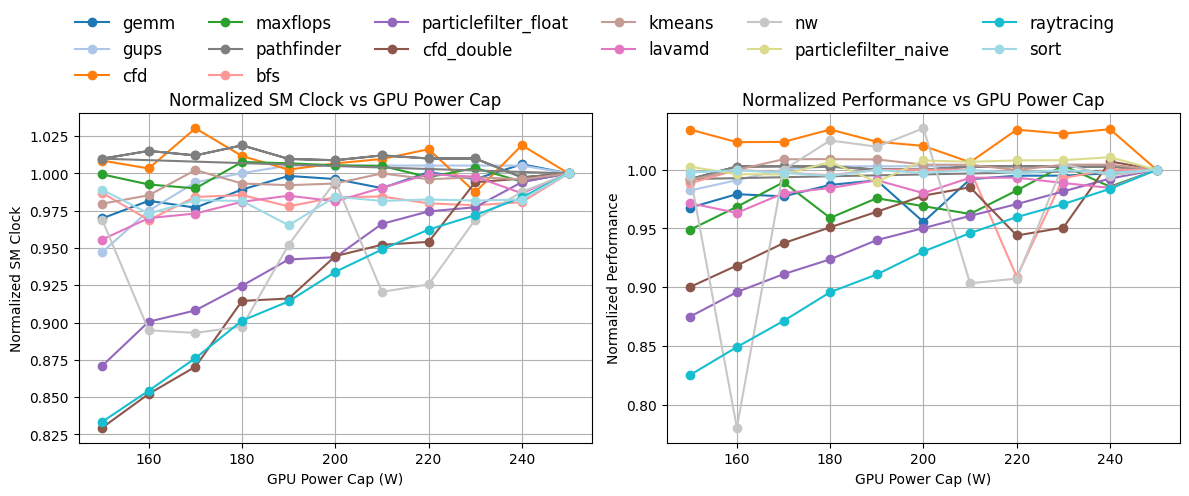

In [11]:
import numpy as np
import itertools

# Function to plot normalized SM Clock and Performance vs GPU Power Cap
def plot_normalized_sm_clock_and_performance(filenames, benchmarks):
    gpu_power_limits = [250, 240, 230,220, 210,200, 190, 180,170,160, 150]
    
    sm_clock_data = {app: [] for app in benchmarks}
    performance_data = {app: [] for app in benchmarks}

    colors = plt.cm.get_cmap("tab20", len(benchmarks)).colors  # Generate distinct colors
    color_cycle = itertools.cycle(colors)
    app_colors = {app: next(color_cycle) for app in benchmarks}

    for file, app in zip(filenames, benchmarks):
        df = pd.read_csv(file)

        # Extract baseline values for normalization (CPU 190W, GPU 250W)
        baseline = df[(df["CPU Power Cap"] == 190) & (df["GPU Power Cap"] == 250)]
        if baseline.empty:
            continue
        base_sm_clock = baseline["SM Clock"].values[0]
        base_performance = baseline["Performance"].values[0]

        for gpu_power in gpu_power_limits:
            subset = df[(df["CPU Power Cap"] == 190) & (df["GPU Power Cap"] == gpu_power)]
            if not subset.empty:
                norm_sm_clock = subset["SM Clock"].values[0] / base_sm_clock if base_sm_clock else np.nan
                norm_performance = subset["Performance"].values[0] / base_performance if base_performance else np.nan
                sm_clock_data[app].append((gpu_power, norm_sm_clock))
                performance_data[app].append((gpu_power, norm_performance))

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

    # Plot Normalized SM Clock vs GPU Power Cap
    for app, data in sm_clock_data.items():
        df_gpu = pd.DataFrame(data, columns=["GPU Power Cap", "Normalized SM Clock"])
        if not df_gpu.empty:
            axs[0].plot(df_gpu["GPU Power Cap"], df_gpu["Normalized SM Clock"], label=f"{app}", marker="o", color=app_colors[app])
    axs[0].set_xlabel("GPU Power Cap (W)")
    axs[0].set_ylabel("Normalized SM Clock")
    axs[0].set_title("Normalized SM Clock vs GPU Power Cap")
    axs[0].grid()

    # Plot Normalized Performance vs GPU Power Cap
    for app, data in performance_data.items():
        df_gpu = pd.DataFrame(data, columns=["GPU Power Cap", "Normalized Performance"])
        if not df_gpu.empty:
            axs[1].plot(df_gpu["GPU Power Cap"], df_gpu["Normalized Performance"], label=f"{app}", marker="o", color=app_colors[app])
    axs[1].set_xlabel("GPU Power Cap (W)")
    axs[1].set_ylabel("Normalized Performance")
    axs[1].set_title("Normalized Performance vs GPU Power Cap")
    axs[1].grid()

    # Add legend
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=6, fontsize=12, frameon=False)

    plt.tight_layout(rect=[0, 0, 1, 0.85])
    plt.show()


    
benchmarks = ['gemm', 'gups', 'cfd','maxflops','pathfinder','bfs','particlefilter_float',
              'cfd_double', 'kmeans', 'lavamd', 'pathfinder', 'nw',
              'particlefilter_naive', 'raytracing','sort']

base_dir = "./altis_power_cap_res/gpu_cap/"
filenames = [base_dir + f"{benchmark}_performance.csv" for benchmark in benchmarks]
# Run the function
plot_normalized_sm_clock_and_performance(filenames, benchmarks)
